----------------------------------------------------------------------------------------------------------
***********************************************************************************************************

# <span style="color:Purple"> From Shallow to Deep Learning 

#### First Project: Image Retrieval (Near Duplicate)

#### Author: Lynda Attouche
#### Link: https://drive.google.com/file/d/1ugvyR9V7ez6RLjvD97kjfI7ZgsyZfBBP/view?usp=sharing
***********************

 The aim of this project is to find an image that has been transformed using point and match detection. It consists of 5 parts:
    
**1)** Uploading the data
    
**2)** Detecting of key points and calculation of descriptors
    
**3)** Finding possible matches, selecting the most descriminating ones and measuring the similarity score between images
    
**4)** Transforming a subset of images and concatenate it with the base dataset
    
**5)** Selecting a transformed image and retrieving the initial image (without transformation) and the top 10 of similar images.

***********************************************************************************************************
----------------------------------------------------------------------------------------------------------


In [ ]:
#update opencv version 
!pip install opencv-contrib-python==4.5.5.62

## 1. Imports

In [ ]:
# libraries and modules
import os
import cv2 as cv
import numpy as np
import torchvision.datasets as datasets
import operator
import  torch.utils
from google.colab import drive
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Loading data

In [ ]:
drive.mount('/content/drive') 
path = "/content/drive/My Drive/Datasets/VOC2007" 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#some checks
os.chdir(path)
os.listdir(path)

['VOCtrainval_06-Nov-2007.tar',
 'VOCtest_06-Nov-2007.tar',
 'VOCdevkit',
 'VOCtrainval_06-Nov-2007.tar (Unzipped Files)']

In [ ]:
#upload image dataset
voc_trainset = datasets.VOCDetection(path,year='2007', image_set='train', download=False)

In [ ]:
#exploring the dataset
print("Total number of images in the data set:",len(voc_trainset))

Total number of images in the data set: 2501


In [ ]:
def loadImage(i,set):
  """
    Load and convert an Image of index i into an array
    @param:
          - i (int): index of the image
    @return: 
          - image (array): the i-th image
  """
  #pick the image from the set
  image = set[i][0]
  return np.array(image)


The example image annotation: 
 {'annotation': {'folder': 'VOC2007', 'filename': '007991.jpg', 'source': {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '331398918'}, 'owner': {'flickrid': 'havasi', 'name': '?'}, 'size': {'width': '500', 'height': '375', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'bird', 'pose': 'Left', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '3', 'ymin': '99', 'xmax': '500', 'ymax': '375'}}]}}
The image


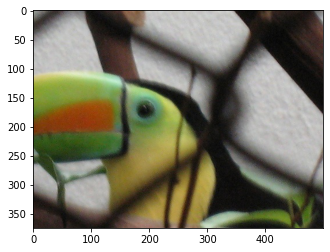

In [ ]:
#example of image manipulation
image = loadImage(2000,voc_trainset) #contrains the image
annotation = voc_trainset[2000][1] #image annotation,description
print("The example image annotation: \n",annotation)
print("The image")
plt.imshow(image)
plt.show()

In [ ]:
#image type
#array since we converted it
type(image)

numpy.ndarray

In [ ]:
#image shape
#it is an RGB image of size 375x500
image.shape

(375, 500, 3)

## 3. KeyPoints Detection and Descriptors Computation

In order to detect the points of interest and calculate their representation (descriptors).
The detection of points corresponds to the detection of points where changes in intensity, contrast and light take place on an image (borders and corners). 
A descriptor is associated with each of these points. It allows to characterize it in a unique way. Thus, a key point has the same descriptor on another image (transformed: orientation, scale,...). Here, I used the SIFT algorithm to detect the key points and calculate their descriptors. This algorithm computes the descriptor of a keypoint using its neighbouring keypoints. It takes a neighbourhood of size 16x16 which is divided into 4x4 sub-blocks (OpenCV documentation). Then, each block is associated with an orientation matrix (8 orientations). And finally, a descriptor will be represented by a vector of size 128 (4x4x8). 


Below is a code containing the function for this process followed by an image test from trainset. 

In [ ]:
def KpDes(image):
  """
  Detects keypoint in a given image ad computes the descriptors
  @params:
          -image(array): image on which we work
  @return: 
          -kp(list): contains the detected keypoints in the image
          -des(array): contrains the descriptors
  """
  #The image is converted to grey scale
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  #SIFT instanciation
  sift = cv.SIFT_create()
  #detecting kp and compute descriptors
  #we use directly the a gray scale image
  #the greyscale version
  kp, des = sift.detectAndCompute(image,None)
  return kp,des


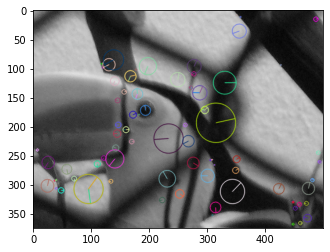

In [ ]:
#example on our image
kp,des = KpDes(image)
#drawing the keypoints on the image
imageKp=cv.drawKeypoints(cv.cvtColor(image, cv.COLOR_BGR2GRAY),kp,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imageKp)
plt.show()

It can be seen in the image above that the key points are the points where there is a change in grey intensity. We can also see circles with an orientation, which corresponds to the one mentioned above

In [ ]:
#analysis
#number of keypoints found
print('Number of keypoints in the example:',len(kp))
#shape of descriptors
# des.shape = (num of keypoints, 4x4x8=128)
# 4x4x8= neighbourhood region shape x orientations
print("Shape of descriptors:",des.shape)


Number of keypoints in the example: 83
Shape of descriptors: (83, 128)


## 4. Matching between pairs of images

### 4.1 All matches

This part of the project aims at obtaining matches between images. Indeed, Now that the key points can be detected, we create pairs of points (matches) which according to their descriptors are similar. 

In a first step I wanted to find "all" possible matches between two images. To do this, I used the BFMatcher and in particular knnMatch, which for each descriptor of the image query returns in my case (k=2) the two best matches. This is done with the following function: 

In [ ]:
def matching(img1,img2):
  """
    Computes matches between 2 images
    @params:
            - img1 (array): query image
            - img2 (array): train image
    @return:
            - matches (list):  matches between the images
            - kp1,kp2 (lists): keypoints of each image
  """
  #keypoints and their descriptors of first image 
  kp1, des1 = KpDes(img1) 
  #keypoints and their descriptors of second image 
  kp2, des2 = KpDes(img2)
  #Creation of BFMatcher object
  #By default this matcher uses the Euclidean norm to calculate the distance
  bf = cv.BFMatcher()

  #Matching 
  #here I used knnMatch
  #it takes as arguments des1 which the set of query descriptors
  #and des2 the set of train descriptors
  #and also k the number of best matches for each query descriptor or less if a query descriptor has less that k possible matches (<=k)
  #it means for each descriptor(each keypoint) of the query image, the algorithm will return 2 matches in the train image  
  matches = bf.knnMatch(des1,des2, k=2)
  return matches,kp1,kp2

The images


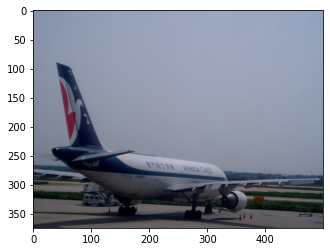

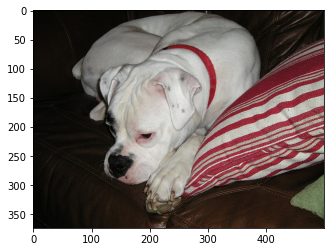

Matching the images


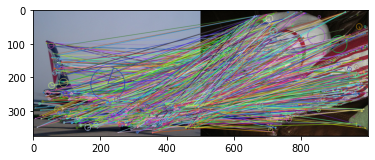

Number of matches is: 357


In [ ]:
#example
#the images to match:
img1,img2 = loadImage(100,voc_trainset),loadImage(2500,voc_trainset)
matches,kp1,kp2 = matching(img1,img2)
print("The images")
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

#drawing the matches
print("Matching the images")
img = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()
print("Number of matches is:",len(matches))

Note that the images below have a fairly high number of matches. This may be due to the fact that the two images have a strong similarity in colour. And it is obvious that they are not all descriminating points. Because in this case, with so many matches, one could say that the images are very similar or even the same image. However, one is a picture of a plane and the other of dog, nonsense! 

### 4.2 Good matches

Then, now that I had all the matches between two images, I sorted them and selected the best. Because as seen in the previous example not all matches are relevent and informative. Thus, a selection has to be made. Besides, only the best should be kept! 

In order to do this, I used the Lowe's ratio test. This is a test that allows for a given keypoint to compare the Euclidean distance between the two matches found. If the distance is large enough then the keypoint is kept, otherwise it is eliminated. I tested several ratios and it turned out that in my case the ratio $0.6$ gave me better results.

Also, in order to measure the similarity between two images, I calculated the ratio of best matches divided by the number keypoints used

In [ ]:
def GoodMatches(img1,img2):
  """
    Computes matches between 2 images
    @params:
            - img1 (array): query image
            - img2 (array): train image
    @return:
            - best_matches (list):  best_matches between the images
            - kp1,kp2 (lists): keypoints of each image
  """
  #compute all the matches
  matches,kp1,kp2 = matching(img1,img2)

  #compute the best matches
  best_matches = []
  ratio = 0.6
  #To test whether a match is relevent/good and should be kept we:
  #Since we have two best matches for each keypoint, we have 2 distances
  # distance between the keypoint and the first best match and
  # distance between the keypoint and the second best match
  # we compare the two measures
  # if they are sufficiently distinct (condition) then the match is kept
  # otherwise it will be discarded (poor match)
  for m1,m2 in matches:
    if m1.distance < ratio*m2.distance:
      best_matches.append([m1])
  
  #similarity score
  #the number of keypoints used during the matching
  number_keypoints = min(len(kp1),len(kp2))
 # print('num',number_keypoints)
  #print('best matches',len(best_matches))
  #print('score',len(best_matches) / number_keypoints)
  #we devide the number of good/relevent keypoints by the the total keypoint used
  score = len(best_matches) / number_keypoints *100
  return best_matches,kp1,kp2,score

Similarity of the images is  1.1204481792717087 %


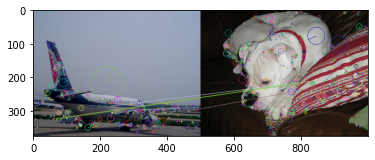

In [ ]:
#example
Gmatches,Gkp1,Gkp2,score = GoodMatches(img1,img2)
print('Similarity of the images is ',score,'%')
#drawing the best matches
imgB = cv.drawMatchesKnn(img1,Gkp1,img2,Gkp2,Gmatches,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imgB)
plt.show()

Finally some clearness! 

No surprise, the two images do not match and the similarity score illustrates this well. 
Thanks to the selection made above, we can now distinguish and conclude if the images match

## 5. Image Transformations

During this step, I applied several transformations (rotations, scaling, affine transformation,..) on 500 images taken from the trainset. Then, I copied (concatenated) these transformed images to the original dataset in order to do the image retrieval. 


### 5.1 Transformations

In [ ]:
#we will consider 200 images indexed from 0 to 199
images = [loadImage(i,voc_trainset) for i in range(0,200)]
len(images)

200

For the geometrical transformations, I used 6 different ones. Some were used simultaneously on the same image. 

So there are: 
>-  **The perspective transformation:** it allows to change the point of view on the image
>-  **The affine transformation:** it transforms each point $(x, y)$ of the image point $(x', y')$ with $x' = ax + by + e$ and $y' = cx + dy + f$ , f being a 3x2 matrix
>-  **Scaling:** it changes the size of the image, here by doubling its size thanks to the factor $2$ which will be detailed in the code
>-  **Translation:** shifts the image here horizontally and vertically with a matrix multiplication
>-  **Rotation:** as its name indicates it allows to rotate an image around a centre with a defined angle



In [ ]:
def transformations(image,perspective,affine,scale,translate,rotate1,rotate2):
  """
  Applies a specific transformation on a given image
  @params:
          - perspective (bool): activates perpective transformation
          - affine (bool): activates affine transformation
          - image (array): image on which we apply transformation
          - scale (bool): activates scaling
          - translate (bool): activates translation
          - rotate1 (bool): activates rotation first type of rotation 
          - rotate2 (bool): activates rotation second type of rotation 

  @return:
          transformed image (array)
  """
  width, height,ch = image.shape
  #copy the initial image
  transformed_image = np.copy(image)

  if perspective:
    #the points of image to be transformed
    pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
    pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])
    #get the perspective matrix
    Mper = cv.getPerspectiveTransform(pts1,pts2) 
    #projecting the image, here the size of the transformed image is (300,300)
    transformed_image = cv.warpPerspective(image,Mper,(300,300))
    width, height,ch = transformed_image.shape

  if affine:
    #3pts(pts1) and their transforms are used to define the matrix of affine transformation
    pts1 = np.float32([[50,50],[200,50],[50,200]])
    pts2 = np.float32([[10,100],[200,50],[100,250]])
    #the obtained matrix:
    Maff = np.float32([[1,0,100],[0,1,50]]) 
    #project the image after affine trasformation
    transformed_image = cv.warpAffine(transformed_image,Maff,(height,width))
    width, height,ch = transformed_image.shape

  if scale:
    #resizing image horizontally and vertically by x2
    #with bicubic interpolation (more accurate)
    transformed_image = cv.resize(image,(2*width, 2*height), interpolation = cv.INTER_CUBIC)
    width, height,ch = transformed_image.shape

  if translate:
    #translation matrix
    #shifting image 100pixels to the right
    #and 50pixels down
    Mtr = np.float32([[1,0,100],[0,1,50]])  
    #projection using affine transformation 
    transformed_image = cv.warpAffine(transformed_image,Mtr,(height,width))
    width, height,ch = transformed_image.shape

  if rotate1:
    #rotation matrix 2x3:
    #((height-1)/2.0,(width-1)/2.0) is the center of rotation and here it is the center of image
    #the angle is 60°
    #1 indicates that the scale is not changed
    Mrot = cv.getRotationMatrix2D(((height-1)/2.0,(width-1)/2.0),60,1) 
    #here an affine transformation(matrix) used to project the rotated image
    transformed_image = cv.warpAffine(transformed_image,Mrot,(height,width))
  
  if rotate2:
    #rotation matrix 2x3:
    #((height-1)/2.0,(width-1)/2.0) is the center of rotation and here it is the center of image
    #the angle is 180°
    #1 indicates that the scale is not changed
    Mrot = cv.getRotationMatrix2D(((height-1)/2.0,(width-1)/2.0),180,1) 
    #here an affine transformation(matrix) used to project the rotated image
    transformed_image = cv.warpAffine(transformed_image,Mrot,(height,width))

  return transformed_image

### 5.2 Test

In order to test the function above, I took a random image and transformed it!

Image before transformations:


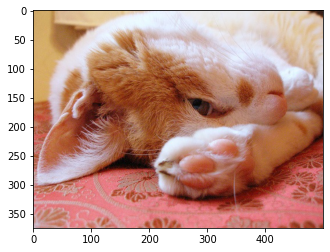

Image after transformations:


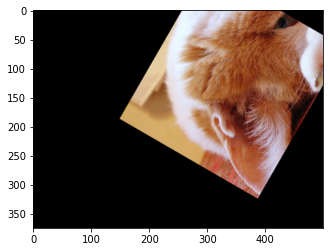

In [ ]:
#Example 
print("Image before transformations:")
plt.imshow(images[99])
plt.show()
print("Image after transformations:")
#I'm using an affine transformation+translation+rotation with 60°
plt.imshow(transformations(images[99],perspective=False,affine=True,scale=False,translate=True,rotate1=True,rotate2=False))
plt.show()

We observed that the image is trasformed as intended

In this following cell, I transformed the 200 images selecte previously, for that I decided to apply different transformation for different images (the choice of the combination was made by just testing). Indeed, I applied 4 types of transformation combinations: 
>- Images indexed from 0 to 49: Affine transformation + Scaling + Rotation 60°
>- Images indexed from 50 to 99: Perspective transformation + Scaling + Rotation 180°
>- Images indexed from 100 to 149: Perspective transformation+ Scaling + Translation
>- Images indexed from 150 to 199: Affine transformation + Scaling + both translation (60°+180° = 240°)

In [ ]:
#list of transformed images
transformed_images = []
#transformations: 
#for each subset of image (each one of length 50), a couple of transformation is applied and stocked in a list:
l1 = [transformations(images[i],perspective=False,affine=True,scale=True,translate=False,rotate1=True,rotate2=False)for i  in range(0,50)]
l2 = [transformations(images[i],perspective=True,affine=False,scale=True,translate=True,rotate1=False,rotate2=True) for i in range(50,100)]
l3 = [transformations(images[i],perspective=True,affine=False,scale=True,translate=True,rotate1=False,rotate2=False) for i  in range(100,150)]
l4 = [transformations(images[i],perspective=False,affine=True,scale=True,translate=False,rotate1=True,rotate2=True) for i in range(150,200)]
#each list of transformed image is added to the global list
transformed_images.extend(l1)
transformed_images.extend(l2)
transformed_images.extend(l3)
transformed_images.extend(l4)

To test if the transformation worked well and has been added properly to the list, I tested by plotting one image

Image before transformation:


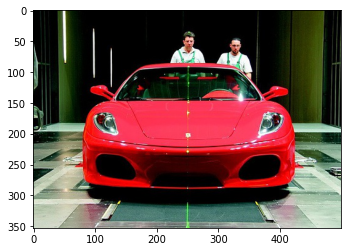

Image after transformation:


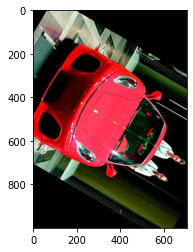

In [ ]:
print('Image before transformation:')
plt.imshow(images[199])
plt.show()
print('Image after transformation:')
plt.imshow(transformed_images[199])
plt.show()

## 5.3 Copy transformed images to trainset

The dataset contrains image of format PIL so I converted the transformed images from arrays to PIL. Also, by looking to the dataset, each image is described by a PIL image and annotation. Since I didn't need the annotation, I didn't add the same format of annotation (with all specific attributes) but just by adding the filename.

In [ ]:
#converting array images to PIL images
transformed_images_pil= [(Image.fromarray(transformed_images[i].astype('uint8'), 'RGB'),{'filename':'transformed'+str(i)+'.jpg'}) for i in range(len(transformed_images))]
type(transformed_images_pil)

list

In [ ]:
#test
transformed_images_pil[2]

(<PIL.Image.Image image mode=RGB size=1000x668 at 0x7F3BDAD54050>,
 {'filename': 'transformed2.jpg'})

In [ ]:
#Concatenating the train set and the transformed images, the latter are added to the tail of the trainset
trainSet= torch.utils.data.ConcatDataset([voc_trainset,transformed_images_pil])
print("Number of images in the train Set after adding the transformed images:",len(trainSet))

Number of images in the train Set after adding the transformed images: 2701


## 6. Image retrieval

Finally, now that I have something to measure the similarity between the images and I have a trainset with transformed and basic images, I can start the image retrieval. So I will choose a transformed image and retrieve the initial image (same untransformed image)

To make things more readable and clear. I decided to define for a given image a list that contains the matches and the score with each image of a given dataset. It is defined as following:

In [ ]:
def matchesDB(img_query,set):
    """
    Creates a list of dictionaries with image and its matches and score with the given image
    @params:
            - img_query (array): query image
            - set (list of arrays): train images
    @return:
            list of dictionaries db
    """
    db = []
    i=0
    matches,kp1,kp2,score =[],[],[],0
    #for each image of the train images
    for img in set:
      #compute matches, scores and keypoints
      matches,kp1,kp2,score = GoodMatches(img_query,img)
      #add them to the list
      db.append({"index":i,"matches": matches,"score":score})
      i+=1
    return db

### 6.1 Test: ranking of images similar to a given image 

For this test, I matched an input image with its similar images (including the image itself). 

The goal here is to see if the algo returns the image itself because the similarity is 100%. And also to see the top 20 of the similar images (test ranking)

In [ ]:
#train images
imgsTest = [loadImage(i,voc_trainset) for i in range(0,10)]
#query image
imgq=loadImage(1,voc_trainset)
#match dictionaries
dbTest = matchesDB(imgq,imgsTest)

The top1 is :1st image, with a score of 100.0 %
The top 20:


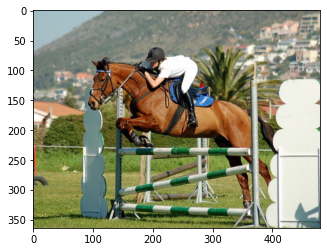

The 1 th top is :1st image, with a score of 100.0 %


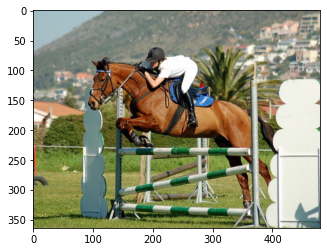

The 0 th top is :1st image, with a score of 1.639344262295082 %


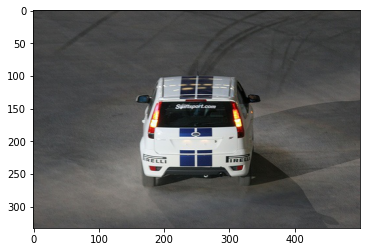

The 9 th top is :1st image, with a score of 0.5444646098003629 %


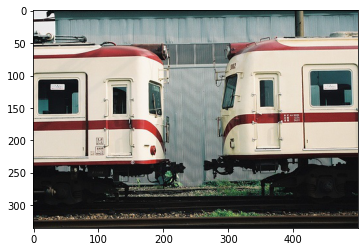

The 3 th top is :1st image, with a score of 0.24096385542168677 %


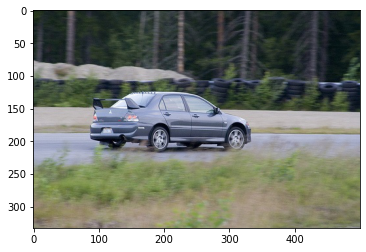

The 5 th top is :1st image, with a score of 0.1984126984126984 %


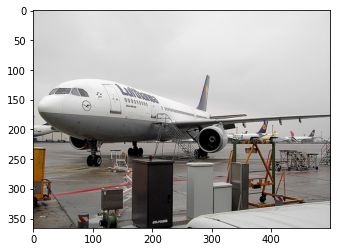

The 2 th top is :1st image, with a score of 0.09514747859181732 %


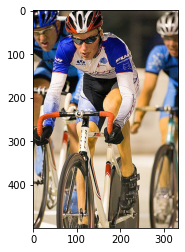

The 6 th top is :1st image, with a score of 0.06523157208088715 %


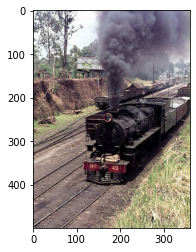

The 4 th top is :1st image, with a score of 0.0 %


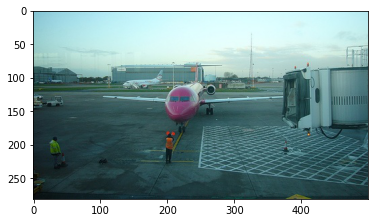

The 7 th top is :1st image, with a score of 0.0 %


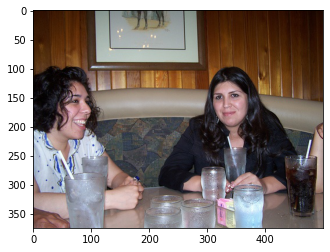

The 8 th top is :1st image, with a score of 0.0 %


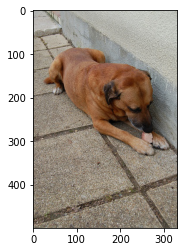

In [ ]:
#Ranking the similar images
dbTest_sorted = sorted(dbTest, key=operator.itemgetter("score"),reverse=True)
#example
top20 = dbTest_sorted[0:20]
#will give first one, with a score of 100%
print("The top1 is :1st image, with a score of",dbTest_sorted[0].get('score'),"%")
print("The top 20:")
plt.imshow(imgq)
plt.show()
for row in top20:
  idx = row.get('index')
  print("The",idx,"th top is :1st image, with a score of",row.get('score'),"%")
  plt.imshow(loadImage(idx,voc_trainset))
  plt.show()

As expected, the first image is the image itself. Then, a series of images was obtained. Some of them belong to the same category but others do not. This can be explained by the fact that the others share the same colours (same intensity in some places). 

### 6.2 Application

Now, after we have seen that the algo works, we will apply it!

To do so, I picked an image "query image" from the transformed images. Then, I will select a subset of images(without the query image itself) and match every image with the query image then rank them to obtain the top10 and more important, find the untransformed image. 

(I selected a subset of images, because by taking all the images it takes a long time so it is just for gaining time, but the result is the same (at least for the top1). I've tried with the whole dataset and I was able to retrieve the image.

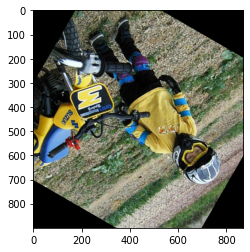

In [ ]:
#queryImage: it is the image I use to obtain extract information
#and the one I'm looking for the untransformed version 
queryImage = loadImage(2670,trainSet)
plt.imshow(queryImage)
plt.show()

In [ ]:
#list of retreive images
#or list of train images 
trainImages = [loadImage(i,trainSet) for i in range(0,300) ]

In [ ]:
#matches: list of matches dictionaries
db = matchesDB(queryImage,trainImages)
#sorting the matches by similarity score
#I used reverse=True, to make a descent sort (from highest score to lowest)
dbSorted = sorted(db, key=operator.itemgetter("score"),reverse=True)

The initial image is the : 169 th image, with a score of 59.12 %


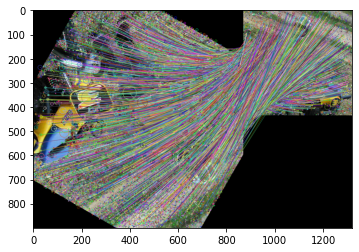

The number of matches is: 1504


In [ ]:
#index of the retrieved image, top1 similar image (non trasformed query)
idx = dbSorted[0].get('index') #getting the index of the image from dictionary
initialImage = loadImage(idx,trainSet) #loading image
#computes good matches between query image and the retrieved image
m,k1,k2,s = GoodMatches(queryImage,initialImage)
print("The initial image is the :",idx,"th image, with a score of",round(dbSorted[0].get('score'),2),"%")
#drawing the best matches
imgB = cv.drawMatchesKnn(queryImage,k1,initialImage ,k2,m,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imgB)
plt.show()
print("The number of matches is:",len(m))

It can be seen that the percentage of matches is quite good (over 50% similarity). There is an impressive number of matches, to the point of not seeing the image anymore. Nevertheless, I find that some points could not be taken into account and this is what has necessarily lowered the score.

Since the output image is not really clear and to be sure that it is the right one, I plotted below.

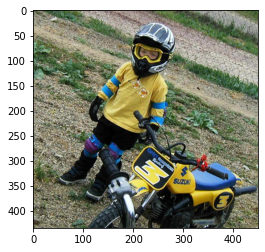

In [ ]:
#since the initial image is not really clear above, it will be plotted alone, so that we will be sure that it is the right image
plt.imshow(initialImage)
plt.show()

In this following code, I plotted the top10 of similar images that I got. For each one, I drew the matches with the query image and printed the score, so we can analyse them. 

The initial image is the : 169 th image, with a score of 59.12 %


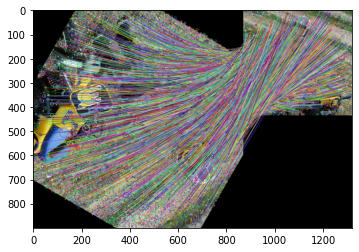

The initial image is the : 201 th image, with a score of 9.8 %


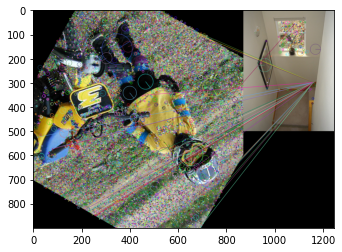

The initial image is the : 195 th image, with a score of 6.78 %


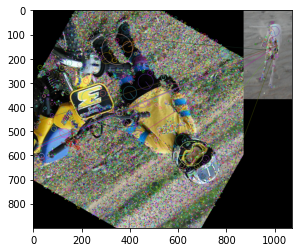

The initial image is the : 299 th image, with a score of 5.37 %


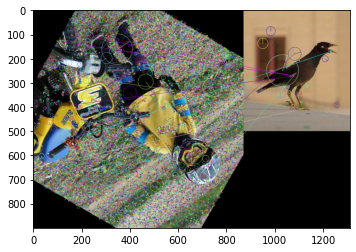

The initial image is the : 232 th image, with a score of 5.19 %


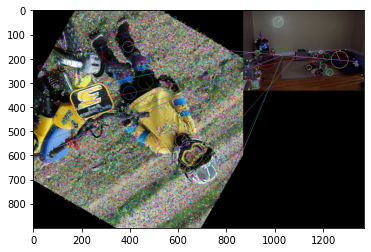

The initial image is the : 10 th image, with a score of 4.44 %


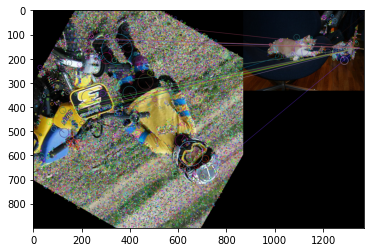

The initial image is the : 55 th image, with a score of 4.23 %


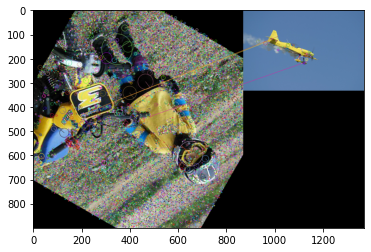

The initial image is the : 193 th image, with a score of 3.93 %


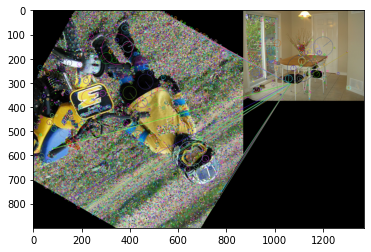

The initial image is the : 194 th image, with a score of 3.8 %


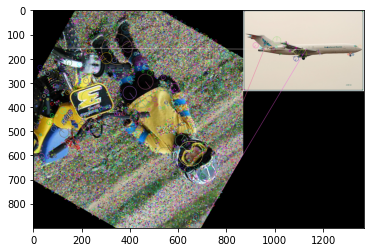

The initial image is the : 24 th image, with a score of 3.25 %


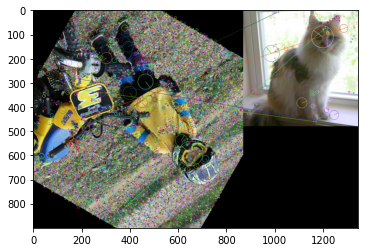

In [ ]:
#top 10 similar images
for i in range(10):
  idx = dbSorted[i].get('index')
  initialImage = loadImage(idx,trainSet)
  #computes good matches between query image and the retrieved image
  m,k1,k2,s = GoodMatches(queryImage,initialImage)
  print("The initial image is the :",idx,"th image, with a score of",round(dbSorted[i].get('score'),2),"%")
  #drawing the best matches
  imgB = cv.drawMatchesKnn(queryImage,k1,initialImage ,k2,m,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  plt.imshow(imgB)
  plt.show()

None of the images obtained (except the first one, obviously) belong to the category of the image: either person or even motorbike. This is not so surprising as with the keypoints we rely more on the intensity changes (colours chages). And I think that the algorithm works well, because despite this rather "funny" ranking and the difference between the categories, the scores reflect these differences well because except for the first one they are very low. What would be really weird or even wrong is to get these images with high scores

I also tested another image that was transformed differently, I I took the same steps:

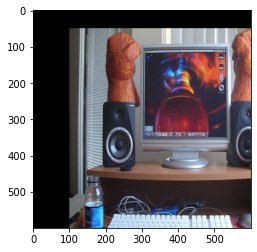

In [ ]:
#queryImage 
queryImage2 = loadImage(2635,trainSet)
plt.imshow(queryImage2)
plt.show()

In [ ]:
#matches
db2 = matchesDB(queryImage2,trainImages)
#sorting the matches by similarity score
dbSorted2 = sorted(db2, key=operator.itemgetter("score"),reverse=True)

The initial image is the : 134 th image, with a score of 29.73 %


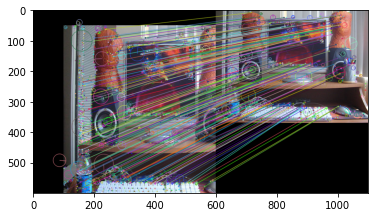

The number of matches is: 217


In [ ]:
#BEST MATCH
#index of the top similar image (non trasformed query)
idx2 = dbSorted2[0].get('index')
initialImage2 = loadImage(idx2,trainSet)
#computes good matches between query image and the retrieved image
m_,k1_,k2_,s_ = GoodMatches(queryImage2,initialImage2)
print("The initial image is the :",idx2,"th image, with a score of",round(dbSorted2[0].get('score'),2),"%")
#drawing the best matches
imgB2 = cv.drawMatchesKnn(queryImage2,k1_,initialImage2 ,k2_,m_,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imgB2)
plt.show()
print("The number of matches is:",len(m_))

The initial image is the : 134 th image, with a score of 29.73 %


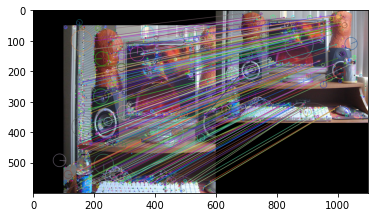

The initial image is the : 201 th image, with a score of 8.63 %


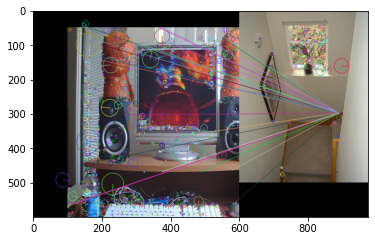

The initial image is the : 88 th image, with a score of 7.81 %


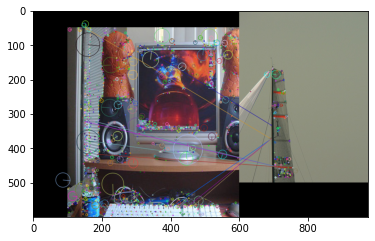

The initial image is the : 195 th image, with a score of 6.78 %


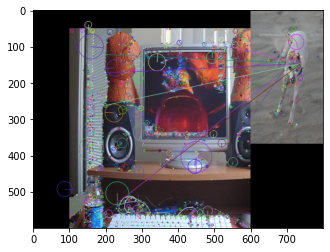

The initial image is the : 299 th image, with a score of 6.71 %


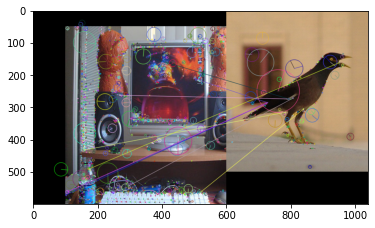

The initial image is the : 165 th image, with a score of 6.27 %


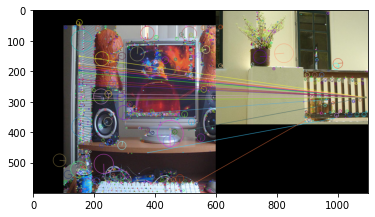

The initial image is the : 263 th image, with a score of 5.9 %


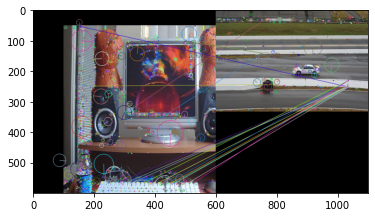

The initial image is the : 171 th image, with a score of 5.3 %


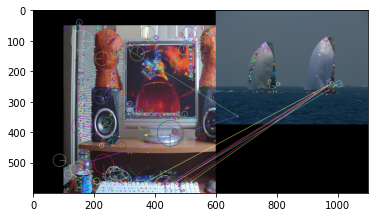

The initial image is the : 232 th image, with a score of 4.72 %


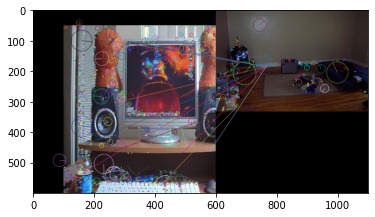

The initial image is the : 151 th image, with a score of 3.86 %


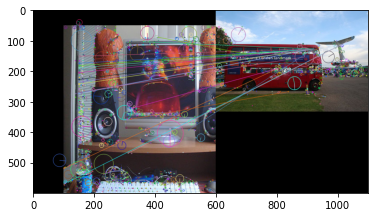

In [ ]:
#top 10 similar images
for i in range(10):
  idx2 = dbSorted2[i].get('index')
  initialImage2 = loadImage(idx2,trainSet)
  #computes good matches between query image and the retrieved image
  m_,k1_,k2_,s_ = GoodMatches(queryImage2,initialImage2)
  print("The initial image is the :",idx2,"th image, with a score of",round(dbSorted2[i].get('score'),2),"%")
  #drawing the best matches
  imgB2 = cv.drawMatchesKnn(queryImage2,k1_,initialImage2 ,k2_,m_,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  plt.imshow(imgB2)
  plt.show()

The results here differ, some have no connection with the category of the image like the 171st image, a category I would define as office, home or even computer. And other images are less well classified but close to the category, like for example the 232nd image.